# GRACE Exploratory Data Analysis

In this process, GRACE data is spatially joined to hydrographic basins, and basin-specific Total Water Storage (TWS) metrics are calculated by aggregating weighted LWE thickness. The result is a dataset with basin-level aggregations and corresponding lat/lon pairs for further analysis. This data will be very useful to add to each observation of the windowed dataset we will generate in the next notebook.

#### Load necessary libraries

In [14]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as Colorbar
import geopandas as gpd
from datetime import datetime
from netCDF4 import Dataset as dt
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.animation as anim
from shapely.geometry import Point, shape, Polygon

## Division/Grouping of the GRACE Grid by Hydrographic Basin

### Loading GRACE and Basin data, and Graphical Representation:

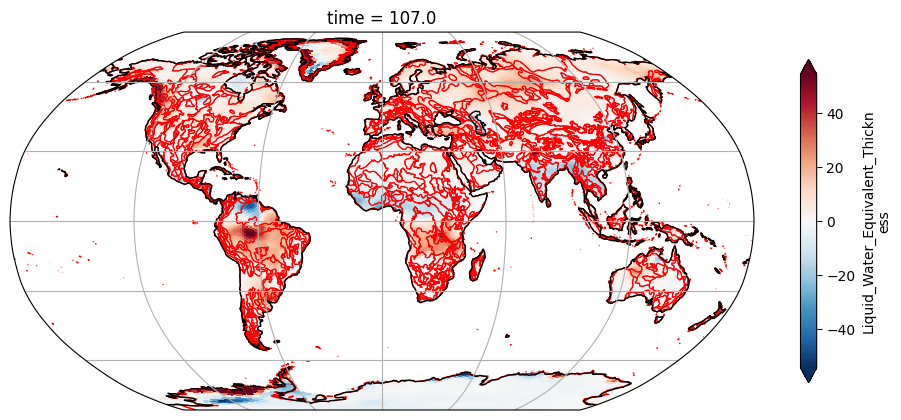

In [115]:
# Load GRACE (TWS) data
grace = xr.open_dataset("Datos/CSR_GRACE_GRACE-FO_RL0602_Mascons_all-corrections.nc")

# Load the land mask dataset
land_mask = xr.open_dataset("Datos/CSR_GRACE_GRACE-FO_RL06_Mascons_v02_LandMask.nc")

# Extract the lwe_thickness variable (TWS)
tws = grace['lwe_thickness']

# Apply the land mask (assuming 1 is land and 0 is ocean)
tws_land_only = tws.where(land_mask['LO_val'] == 1)

# Load the groundwater basins shapefile
basins = gpd.read_file("Datos/WHYMAP_basins/whymap_GW_aquifers_v1_poly.shp")

# Create the figure and axis with the Robinson projection
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()  # Add coastlines to the plot
ax.gridlines()  # Add gridlines to the plot

# Plot the total water storage over land (first time frame)
tws_land_only.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.7}, robust=True)

# Add groundwater basin boundaries
# Convert the basin geometries to the same projection before plotting
basins.to_crs(epsg=4326).plot(ax=ax, facecolor="none", edgecolor='red', linewidth=0.8, transform=ccrs.PlateCarree())

# Display the plot
plt.show()

In [116]:
basins.head()

,HYGEO2,ICE,CONTINENT,geometry
0,33,88,99,"POLYGON ((-27.619 81.475, -27.846 81.465, -28...."
1,33,88,99,"POLYGON ((-39.031 83.286, -39.174 83.287, -39...."
2,33,88,99,"POLYGON ((-38.84 83.107, -38.899 83.108, -38.9..."
3,33,88,99,"POLYGON ((-41.253 83.285, -41.39 83.293, -41.5..."
4,33,88,99,"POLYGON ((-42.149 83.241, -42.382 83.245, -42...."


### Example of a specific basin in Europe

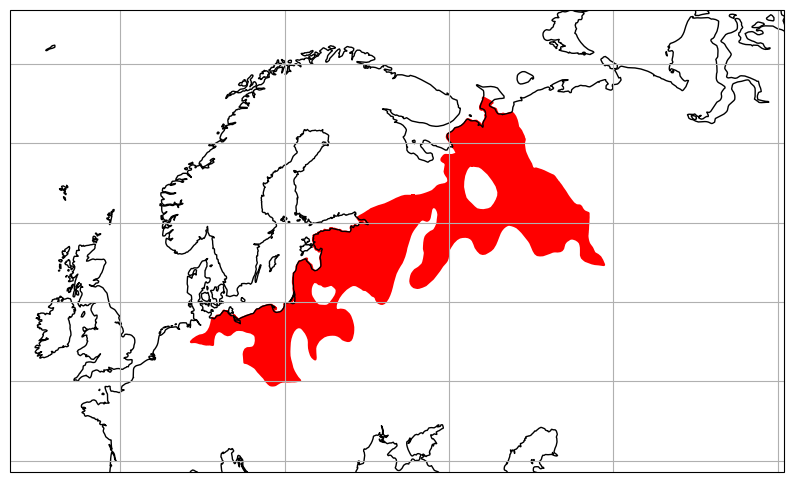

In [158]:
from shapely.geometry import mapping
import matplotlib.pyplot as plt

# Extract latitude and longitude coordinates from the GRACE dataset
lons = tws.coords['lon'].values
lats = tws.coords['lat'].values

# Create a mesh grid of longitude and latitude points
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Flatten the latitude and longitude grids
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Create Point objects from the latitude and longitude coordinates
points = [Point(lon, lat) for lon, lat in zip(lon_flat, lat_flat)]

# Create a boolean mask: True if the point is within the basin, False otherwise
mask = np.array([basin_polygon.contains(point) for point in points])

# Reshape the mask to match the original grid shape of latitude and longitude
mask = mask.reshape(lon_grid.shape)

# Get the bounds of the basin for adjusting the plot's visualization
basin_bounds = example_basin.total_bounds  # [minx, miny, maxx, maxy]

# Add some buffer around the basin bounds to reduce zoom for better visibility
buffer_factor = 5.5  # Controls the amount of extra area added around the basin
lon_min = basin_bounds[0] - 4 * buffer_factor
lon_max = basin_bounds[2] + 4 * buffer_factor
lat_min = basin_bounds[1] - buffer_factor
lat_max = basin_bounds[3] + buffer_factor

# Create the figure and axis using PlateCarree projection for accurate proportions
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Set the plot limits

# Add coastlines and gridlines for reference
ax.coastlines()
ax.gridlines()

# Add the boundary of the selected basin to the plot
example_basin.to_crs(epsg=4326).plot(ax=ax, facecolor="red", edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())

# Display the plot
plt.show()

### Selection of a subset of the available basins

In [159]:
# Calculate the area of each basin (in square meters) and add it as a new column
# The CRS is converted to EPSG:3395 (World Mercator) to ensure the area is calculated in meters
basins['area_m2'] = basins.to_crs(epsg=3395)['geometry'].area

# Sort the basins by area in descending order
basins_sorted = basins.sort_values(by='area_m2', ascending=False)

In [160]:
basins_sorted.head()

,HYGEO2,ICE,CONTINENT,geometry,area_m2
3423,88,88,99,"MULTIPOLYGON (((-56.946 -63.451, -56.785 -63.5...",3.545216e+15
3412,33,0,5,"MULTIPOLYGON (((142.3 72.703, 142.48 72.698, 1...",4.065343e+13
20,88,88,99,"POLYGON ((-27.619 81.475, -27.578 81.464, -27....",2.456496e+13
144,33,0,5,"POLYGON ((83.167 70.081, 83.18 70.086, 83.194 ...",1.268572e+13
367,33,0,1,"POLYGON ((-135.45 68.71, -135.65 68.314, -135....",9.525504e+12


#### We select the top 5% basins in terms of area

In [161]:
# Sort basins by area in descending order and calculate the 95th percentile
percentile_95_area = basins['area_m2'].quantile(0.95)

# Create a DataFrame with basins that are part of the largest 5%
selected_basins = basins[basins['area_m2'] >= percentile_95_area]

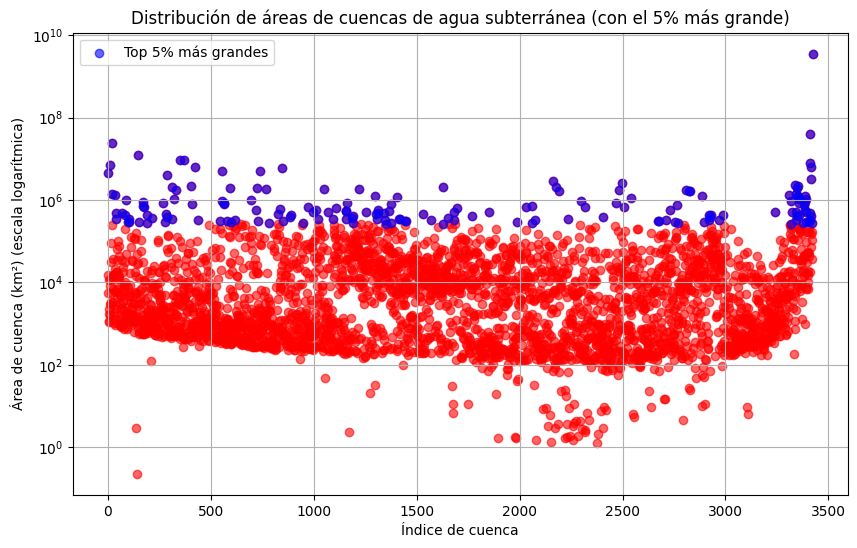

In [165]:
# Scatter plot: all basins in red and the largest 5% in blue
plt.figure(figsize=(10, 6))

# Scatter plot for all basins in red
plt.scatter(basins.index, basins['area_m2'] / 1e6, color='red', alpha=0.6)

# Scatter plot for the top 5% largest basins in blue
plt.scatter(selected_basins.index, selected_basins['area_m2'] / 1e6, color='blue', alpha=0.6, label='Top 5% largest')

# Set y-axis to logarithmic scale for better visibility
plt.yscale('log')

# Labels and title for the plot
plt.xlabel('Basin Index')
plt.ylabel('Basin Area (km²) (log scale)')
plt.title('Distribution of Groundwater Basin Areas (with Top 5% Largest Highlighted)')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### We check how much of the Earth's surface do theese basins cover

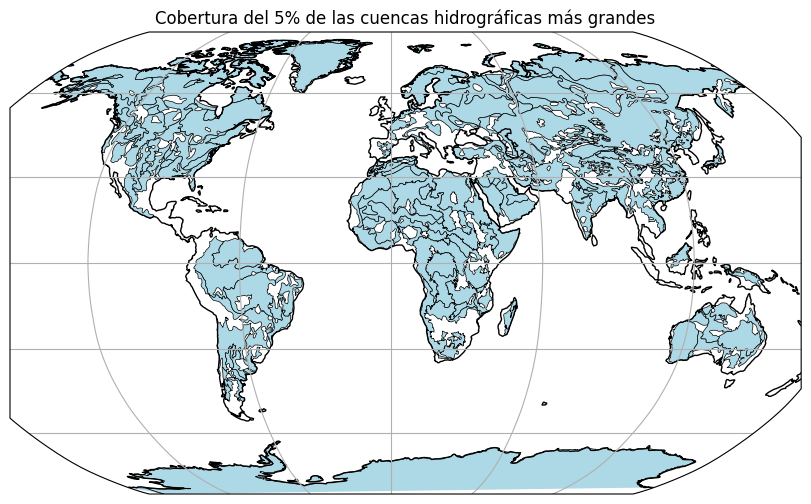

In [163]:
# Create the figure and axis with Robinson projection for a global map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Plot only the largest 5% basins with light blue color and black borders
selected_basins.to_crs(epsg=4326).plot(ax=ax, facecolor='lightblue', edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

# Add a title to the map
ax.set_title('Coverage of the Top 5% Largest Groundwater Basins')

# Display the plot
plt.show()

In [164]:
# Step 1: Calculate the total area of all basins
area_total_m2 = basins['area_m2'].sum()
area_total_km2 = area_total_m2 / 1e6  # Convert to km²
print(f"Total area of all basins: {area_total_km2:,.2f} km²")

# Step 2: Calculate the total area of the selected basins (top 5%)
area_cuencas_m2 = selected_basins['area_m2'].sum()
area_cuencas_km2 = area_cuencas_m2 / 1e6  # Convert to km²
print(f"Total area of selected basins: {area_cuencas_km2:,.2f} km²")

# Step 3: Calculate the coverage percentage of selected basins
porcentaje_cobertura = (area_cuencas_m2 / area_total_m2) * 100
print(f"The selected basins cover approximately {porcentaje_cobertura:.2f}% of the Earth's surface.")

Área total de todas las cuencas: 3,873,197,783.02 km²
Área total de las cuencas seleccionadas: 3,811,711,450.49 km²
Las cuencas seleccionadas cubren aproximadamente el 98.41% de la superfície terrestre.


### Transforming from a geopandas to a standard dataframe 

In [173]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import gc  # Import garbage collection to manage memory

# Extract latitude and longitude coordinates from the GRACE dataset
lons = grace.coords['lon'].values  # Ensure coordinate names are correct
lats = grace.coords['lat'].values

# Create a meshgrid for latitude and longitude values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Flatten the latitude and longitude arrays to generate a list of coordinates
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# List to store all data frames generated for each time index
df_list = []

# Iterate over all time indices in the GRACE dataset (currently iterating over the first one for testing)
for time_index in range(1):
    print(f"{time_index + 1}/{len(grace.coords['time'])}")  # Track iteration progress

    # Extract the current time value
    time_value = grace.coords['time'].values[time_index]

    # Extract lwe_thickness data for the current time
    variable_data = grace['lwe_thickness'].isel(time=time_index).values.flatten()

    # Create a DataFrame to hold longitude, latitude, lwe_thickness, and time
    grace_df = pd.DataFrame({
        'lon': lon_flat,
        'lat': lat_flat,
        'lwe_thickness': variable_data,
        'time': time_value
    })

    # Adjust longitudes to the range -180 to 180 for standard geographic plotting
    grace_df['lon'] = ((grace_df['lon'] + 180) % 360) - 180

    # Generate geometries (latitude, longitude points)
    geometry = gpd.points_from_xy(grace_df['lon'], lat_flat, crs="EPSG:4326")

    # Add geometry column to the DataFrame
    grace_df['geometry'] = geometry

    # Append the DataFrame for the current time index to the df_list
    df_list.append(grace_df)
    
    # Clean up large objects to manage memory
    del grace_df, variable_data, time_value
    gc.collect()

# Concatenate all the DataFrames from the time iterations into one
full_df = pd.concat(df_list, ignore_index=True)

# Convert the combined DataFrame into a GeoDataFrame for spatial operations
full_gdf = gpd.GeoDataFrame(full_df, geometry='geometry', crs="EPSG:4326")

# Clean up df_list after concatenation to free up memory
del df_list
gc.collect()

1/233


0

## Assignment of the different (lon, lat) pairs to the corresponding basin

In [174]:
# Ensure both GeoDataFrames are in the same coordinate reference system (CRS)
selected_basins = selected_basins.to_crs("EPSG:4326")
full_gdf = full_gdf.to_crs("EPSG:4326")

# Perform the spatial join to assign each (lon, lat) point to its corresponding basin
grace_with_basins = gpd.sjoin(full_gdf, selected_basins, how='inner', predicate='within')

In [175]:
# Rename the 'index_right' column to 'basin_id' for better clarity
grace_with_basins = grace_with_basins.rename(columns={'index_right': 'basin_id'})

In [176]:
len(grace_with_basins.basin_id.unique())

172

In [177]:
# Define a function to calculate the area of a cell based on its central latitude
def cell_area(lat, lat_res=0.25, lon_res=0.25):
    """
    Calculate the area of a grid cell on the Earth's surface based on latitude and resolution.

    Parameters:
    - lat: Latitude of the cell center (in degrees)
    - lat_res: Latitude resolution of the grid cell (default is 0.25 degrees)
    - lon_res: Longitude resolution of the grid cell (default is 0.25 degrees)

    Returns:
    - Area of the cell in square meters.
    """
    R = 6371000  # Earth's average radius in meters
    lat_rad = np.radians(lat)  # Convert latitude to radians
    lat_res_rad = np.radians(lat_res)  # Convert latitude resolution to radians
    lon_res_rad = np.radians(lon_res)  # Convert longitude resolution to radians
    # Calculate the cell area using spherical geometry
    area = (R**2) * lon_res_rad * (np.sin(lat_rad + lat_res_rad / 2) - np.sin(lat_rad - lat_res_rad / 2))
    return area  # Return area in square meters

# Apply the cell_area function to each latitude point in the dataset
grace_with_basins['cell_area'] = grace_with_basins['lat'].apply(cell_area)

In [178]:
# Calculate 'weighted_lwe_thickness' for each point by multiplying lwe_thickness by the cell area
grace_with_basins['weighted_lwe_thickness'] = grace_with_basins['lwe_thickness'] * grace_with_basins['cell_area']

# Group by 'basin_id' and 'time', and calculate the sum of 'weighted_lwe_thickness' and 'cell_area'
# Also calculate the mean 'area_m2' for each basin
basin_aggregations = grace_with_basins.groupby(['basin_id', 'time']).agg({
    'weighted_lwe_thickness': 'sum',  # Sum the weighted lwe_thickness for each basin
    'cell_area': 'sum',  # Sum the cell areas within each basin
    'area_m2': 'mean'  # Take the mean of the basin area (it should be the same for all points within a basin)
}).reset_index()

In [180]:
basin_aggregations['time'] = pd.to_datetime(basin_aggregations['time'], format='%d-%m-%Y')
basin_aggregations['month'] = basin_aggregations['time'].dt.month
basin_aggregations['year'] = basin_aggregations['time'].dt.year

In [181]:
basin_aggregations.sort_values(by = ['basin_id', 'year', 'month'])

,basin_id,time,weighted_lwe_thickness,cell_area,area_m2,month,year
0,0,2002-04-18,2.937000e+12,8.230813e+10,4.567004e+12,4,2002
1,9,2002-04-18,7.691643e+12,1.972861e+11,7.222754e+12,4,2002
2,19,2002-04-18,2.488603e+12,3.596704e+10,1.433314e+12,4,2002
3,20,2002-04-18,5.553670e+13,1.649092e+12,2.456496e+13,4,2002
4,34,2002-04-18,-1.784194e+09,4.113084e+10,1.323979e+12,4,2002
...,...,...,...,...,...,...,...
167,3414,2002-04-18,9.108934e+12,8.577670e+11,3.294348e+12,4,2002
168,3415,2002-04-18,1.961374e+13,1.378333e+12,6.171374e+12,4,2002
169,3417,2002-04-18,1.851888e+12,9.680411e+10,4.031389e+11,4,2002
170,3420,2002-04-18,8.064568e+11,9.159766e+10,2.705822e+11,4,2002


In [188]:
def extract_lat_lon_pairs(df):
    """
    Groups the DataFrame by 'basin_id' and creates lists of latitude and longitude pairs for each group.
    
    Parameters:
    df (DataFrame): The input DataFrame with latitude and longitude columns.
    
    Returns:
    DataFrame: A DataFrame with 'basin_id' and corresponding lists of latitude and longitude pairs.
    """
    # Group by 'basin_id' and aggregate latitudes and longitudes into lists
    return df.groupby('basin_id').apply(
        lambda x: {'lat': x['lat'].tolist(), 'lon': x['lon'].tolist()}
    ).reset_index(name='lat_lon_pairs')

# Apply the function to the complete DataFrame to get lat/lon pairs for each basin
basin_lat_lon = extract_lat_lon_pairs(grace_with_basins)

C:\Users\local_sds708\Temp\ipykernel_6436\344737738.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('basin_id').apply(


In [189]:
# Combine the aggregations with the latitude and longitude pairs
basin_df = pd.merge(basin_aggregations[['time', 'basin_id', 'area_m2']], basin_lat_lon, on='basin_id')

In [191]:
basins_sorted['basin_id'] = basins_sorted.index

In [193]:
basin_df = pd.merge(basin_df, basins_sorted.drop(['area_m2'], axis = 1), on='basin_id')

In [194]:
basin_df.head()

,time,basin_id,area_m2,lat_lon_pairs,HYGEO2,ICE,CONTINENT,geometry
0,2002-04-18,0,4.567004e+12,"{'lat': [80.625, 80.625, 80.625, 80.625, 80.62...",33,88,99,"POLYGON ((-27.619 81.475, -27.846 81.465, -28...."
1,2002-04-18,9,7.222754e+12,"{'lat': [76.375, 76.375, 76.375, 76.375, 76.37...",33,88,1,"POLYGON ((-76.231 82.445, -76.184 82.454, -76...."
2,2002-04-18,19,1.433314e+12,"{'lat': [79.875, 79.875, 79.875, 79.875, 79.87...",33,88,99,"POLYGON ((-16.916 81.856, -17.054 81.837, -16...."
3,2002-04-18,20,2.456496e+13,"{'lat': [60.375, 60.375, 60.625, 60.875, 60.87...",88,88,99,"POLYGON ((-27.619 81.475, -27.578 81.464, -27...."
4,2002-04-18,34,1.323979e+12,"{'lat': [78.375, 78.375, 78.375, 78.375, 78.37...",33,88,1,"POLYGON ((-94.671 80.057, -94.749 80.08, -94.7..."


### Save the resulting dataframe

In [196]:
basin_df.to_csv('basin_info_df.csv')